# Multidimensional interpolation with radial basis functions

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# get rbf from here: 
#   https://github.com/treverhines/RBF.git
#   https://github.com/NelisW/RBF (forked from above)
# rbf has a poly.c file that must be compiled to a poly.pyx file.
# it seem that different versions of Python require recompile of the file.
# to do this cd to the folder that contains setup.py (RBF/) and then
#   python setup.py install
# this will install rbf in the Lib/sitepackages folder, ready for work.

from rbf.interpolate import RBFInterpolant

import pandas as pd
from scipy.interpolate import Rbf
from scipy.interpolate import InterpolatedUnivariateSpline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline


https://en.wikipedia.org/wiki/Radial_basis_function
https://en.wikipedia.org/wiki/Radial_basis_function_kernel  
https://www.youtube.com/watch?v=_cJLVhdj0j4&t=43s  
https://www.youtube.com/watch?v=bPmj4byYbhg&t=67s  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html  
https://stackoverflow.com/questions/47364660/how-to-use-scipy-interpolate-rbf-in-n-dimensions  
http://scipy-cookbook.readthedocs.io/items/RadialBasisFunctions.html  
https://www.comsol.com/blogs/using-radial-basis-functions-for-surface-interpolation/

        
        

A radial basis function (RBF) is a real-valued function whose value depends only on the distance from the origin, so that 
$\ \phi \left(\mathbf {x} \right)=\phi \left(\left\|\mathbf {x} \right\|\right))$; 
or alternatively on the distance from some other point $\textstyle \mathbf {c}$, called a center, 
$\phi \left(\mathbf {x} ,\mathbf {c} \right)=\phi \left(\left\|\mathbf {x} -\mathbf {c} \right\|\right)$.
Any function $\phi$ that satisfies the property $\phi \left(\mathbf {x} \right)=\phi \left(\left\|\mathbf {x} \right\|\right)$ is a radial function. The norm $||$ is usually Euclidean distance, although other distance functions are also possible.

Sums of radial basis functions are typically used to approximate given functions. This approximation process can also be interpreted as a simple kind of neural network; this was the context in which they originally surfaced, in work by David Broomhead and David Lowe in 1988, which stemmed from Michael J. D. Powell's seminal research from 1977.  RBFs are also used as a kernel in support vector classification.

In broad principles, the radial basis function interpolation method works as follows:
    
1. Imagine an RBF kernel $\phi$ (e.g., a Gaussian) centred at each data point.
1. It would appear that all the kernels have the same mathematical 'width' or scale in all dimensions.
1. The interpolated value is given by the weighted sum of all the kernels, over all the data points. The weights $w_i$ can be positive or negative. Clearly, the further the points are removed  from each other the lesser their contribution to the value at the respective points.
$$f(x) = \sum_i w_i\phi(||x-c_i||)$$
    
2. The magnitude or weights whereby each of these kernels contribute to the final signal is determined by solving a linear algebra calculation.  Solve for $w_i$ in 
$$f(c_j) = \sum_i w_i \phi(||c_j-c_i||)$$
   In the naive approach (I suspect practical solutions are more complex):
   In 1-D there are $N$ equations and $N$ unknowns, it can be solved linearly.
   In n-D there are $Nm$ equations and $Nm$ unknowns, it can be solved linearly.

1. As part of the solution, the user must estimate an optimal value for a parameter called epsilon. This epsilon can be considered something like a lateral width: how much should kernels affect each other, given certain distance between them.  It appears that the selection of epsilon is important and should be considered carefully.
1. With the epsilon, kernel type, width and weights known, the sum of all kernels can be used to determine the interpolated value.

1. One of the properties of RBF interpolation is that, if the ideal mathematical solution is used, the resultant interpolated function  passes through the sample points.  Most implementations offer a 'penalty' factor that would smooth the function but at the cost of not passing through the sample points.

The n-dimensional input values should be scaled to cover more or less the same domain scope, because these domains contribute/compete equally in the radial function distance. Suppose one dimension varies over a domain of (0,1e4) and another domain varies over a domain of (0,1) then clearly the first domain will dominate any attempt at calculating distance from a kernel centre.  Therefore normalise the input domains to cover similar scope.  
https://www.researchgate.net/post/Why_normalization_is_necessary_in_ANN  
https://visualstudiomagazine.com/articles/2014/01/01/how-to-standardize-data-for-neural-networks.aspx  
https://www.coursera.org/lecture/deep-neural-network/normalizing-inputs-lXv6U  

Considering how this radial basis function interpolation is defined, one can almost consider this a feed-forward two-layer neural net, where the first layer is a trivial input layer that must scale each dimension's input.  There is only one set of weights to be solved and these weights can be found in a single calculation.

This graph shows how the sum of all the kernels are used to approximate the curve by their respective weights.


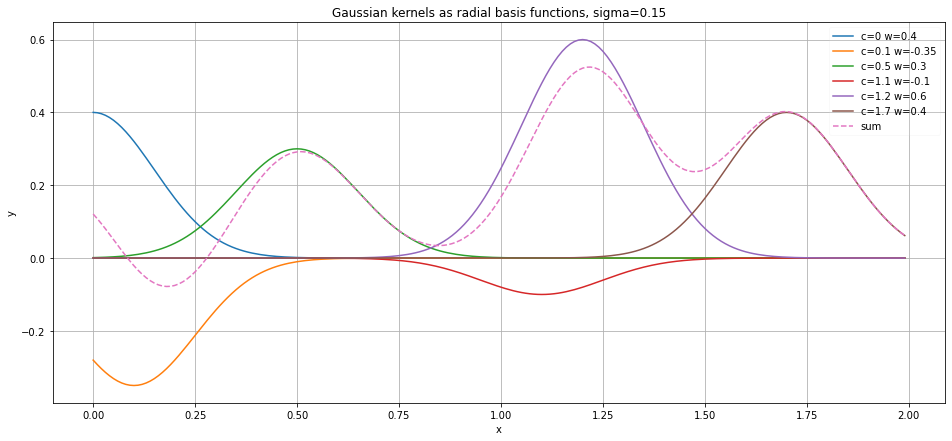

In [2]:

def gausskernel(t,sigma,shift):
    return np.exp(-0.5 * ((t-shift)/sigma) ** 2)

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
fig, ax = plt.subplots(figsize=(16,7))

kernels = []
sigma = 0.15
shifts =  [0,  0.1,  .5, 1.1, 1.2, 1.7]
weights = [0.4, -0.35, 0.3, -0.1, 0.6, 0.4]
sum = np.zeros(t.shape)
for i, (shift,weight) in enumerate(zip(shifts,weights)):
    kernels.append(weight * gausskernel(t,sigma=sigma,shift=shift))
    sum += kernels[-1]
    ax.plot(t, kernels[-1],label=f'c={shift} w={weight}')

ax.plot(t, sum, label='sum',linestyle='--')

ax.set(xlabel='x', ylabel='y',
       title=f'Gaussian kernels as radial basis functions, sigma={sigma}')
ax.legend(loc='best', fancybox=True, framealpha=0.1)
ax.grid()


## Mesh Free

Notice that the RBF approach places no constraints on where the sample point must be: it is completely mesh-free.  This is in contrast with structured meshes which are required for simple linear interpolation methods and unstructured meshes such as Delaunay triangulation or geodesic sampling, where there must be some information on how the sample points fit together in the mesh.

In the RBF approach, the sample points can be anywhere in the domain space.
each sample is completely independent from any other sample. 

it can be more dense in some areas and less dense in other areas.  The points can also be placed completely randomly.  This means that you can add new sample points at any time to the existing set. However, each time a new sample point is added you must compute the new weights; which can be an expensive operation.

## Kernel Functions

There are a large number of functions, here are just a few of the well documented kernel functions (all centred at 0).

Linear: 
$$r$$

Cubic: 
$$r^3$$

Quintic: 
$$r^5$$

Gaussian (note that $\epsilon=1/\sigma$):
$$\phi \left(r\right)=e^{-\left(\varepsilon r\right)^{2}}$$

Multiquadric:
$$\phi \left(r\right)={\sqrt {1+\left(\varepsilon r\right)^{2}}} $$

Inverse quadratic:
$$\phi \left(r\right)={\dfrac {1}{1+\left(\varepsilon r\right)^{2}}} $$

Inverse multiquadric:
$$\phi \left(r\right)={\dfrac {1}{\sqrt {1+\left(\varepsilon r\right)^{2}}}} $$

Polyharmonic spline:
$${\begin{aligned}\phi \left(r\right)&=r^{k},&k&=1,3,5,\dotsc \\\phi \left(r\right)&=r^{k}\ln \left(r\right),&k&=2,4,6,\dotsc \end{aligned}}$$

Thin plate spline (a special polyharmonic spline):
$$\phi \left(r\right)=r^{2}\ln \left(r\right)$$


** Note ** There are two conventions in $\epsilon$ definition: The two conventions are each the inverse of the other, take care when reading.

Some of the RBF have an $\epsilon$ parameter that determines the width or significant reach of the function. For example, in the notation of the Gauss function above, for $x > 3\sigma$, i.e., $x >3/\epsilon$ a Gauss function has near-zero value and its support is insignificant.
As $\epsilon\rightarrow 0$ the width becomes larger and the function is 'flatter' (it reaches further out from the center). Clearly the value of $\epsilon$  must be tuned to match the density of the sample points.  If the distance between the samples is large compared to the RBF width (too high a value  of $\epsilon$), there will be no support from any of the sample points between the widely space samples.  A nice example is shown below in Trever Hines sample code.



## When to use Radial Basis Functions

1.  In *Fast Radial Basis Functions for Engineering Applications*, Biancolini writes the following:

    At a first glance RBF implementation seems to be an easy task, but what usually happens to practitioners is that this first positive experience is followed by a substantial disappointment when the limit of the simple approach is discovered. The
complexity of the fit grows with a power of 3 with respect to the number of RBF centres, whilst the cost of an evaluation of the RBF at a single point and storage space grows with a power of 2. This means that the practical limit of a problem that
can be managed is about 10,000 points, value that is high enough to experiment with engineering problems, but not satisfactory for the production of effective industrial solutions. This is why RBF have a bad reputation and are often perceived as an interesting tool suitable for theoretical investigations but useless for practical applications.

1. From [here](https://pro.arcgis.com/en/pro-app/help/analysis/geostatistical-analyst/how-radial-basis-functions-work.htm):

  RBFs are used to produce smooth surfaces from a large number of data points. The functions produce good results for gently varying surfaces such as elevation.

  However, the techniques are inappropriate when large changes in the surface values occur within short distances and/or when you suspect the sample data is prone to measurement error or uncertainty.
  
3. If the data samples are in mesh-free format.

4. The initial weight calculation is an O($n^3$) calculations which means that for a large number of data samples, the computational load grows very quickly.

## Interpolation on a sphere

This might be an important paper (it even has Matlab code!):

https://amath.colorado.edu/faculty/fornberg/Docs/Fornberg_Piret.pdf


    

## Scipy Implementation

The Scipy Python package provides a RBF interpolation functionality.

**Note** Scipy convention for $\epsilon$ is that $\epsilon = \sigma$ in a Gauss function.

`class scipy.interpolate.Rbf(*args)` provides a multidimensional interpolation function that uses any of the following radial base functions (`multiquadric` is default):

    `function=`
    'multiquadric': sqrt((r/self.epsilon)**2 + 1)
    'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
    'gaussian': exp(-(r/self.epsilon)**2)
    'linear': r
    'cubic': r**3
    'quintic': r**5
    'thin_plate': r**2 * log(r)
    
You can also set the smoothness of the fit, see the documentation. See also here https://github.com/scipy/scipy/issues/4523


In [3]:
# from scipy docs
# pass node coordinates as separate values in function call
x, y, z, d = np.random.rand(4, 50)
rbfi = Rbf(x, y, z, d)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
rbfi(xi, yi, zi)   # interpolated values


array([1.1716486 , 0.8270142 , 0.43069369, 0.16362441, 0.20231944,
       0.47472918, 0.73514442, 0.79948529, 0.68864697, 0.57787355,
       0.52803064, 0.44239698, 0.28596845, 0.16160972, 0.1545623 ,
       0.23087277, 0.3183755 , 0.3991764 , 0.47909543, 0.55995983])

In the following example the input is five-dimensional and unpacked by the `*` in the function call.

Note that because of the unpacking the first dimension's values are `[ 0  1  2  3  4]`, the second are `[ 5  6  7  8  9]`, and the values at the nodes are `[25 26 27 28 29]`.  One would intuitively want the dimensions and values to be the columns in the input array, but it is in fact the rows, because of the unpacking.

In [4]:
# https://pythontips.com/2013/08/04/args-and-kwargs-in-python-explained/ 
def testArgs(row,*argv):
    return argv[row]

In [5]:
# from stackoverflow answer
# pass node coordinates as unpacked values in function call
a = np.arange(30)
a = a.reshape((6,5))    
print(a)
print('------------')
row = 0
print(f'{row}th dimension: {testArgs(0,*a)}')
print('------------')
f = Rbf(*a)    
o = f((2,3),(7,8),(12,13),(17,18),(22,23))
print(o)
print('------------')
x = np.array((4,9,14,19,24))
o = f(*x)
print(o)


[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]]
------------
0th dimension: [0 1 2 3 4]
------------
[27. 28.]
------------
29.0


## Using radial basis functions for smoothing/interpolation

http://scipy-cookbook.readthedocs.io/items/RadialBasisFunctions.html



Radial basis functions can be used for smoothing/interpolating scattered data in n-dimensions, but should be used with caution for extrapolation outside of the observed data range.

### 1-D example

This example compares the usage of the Rbf and UnivariateSpline classes from the scipy.interpolate module.


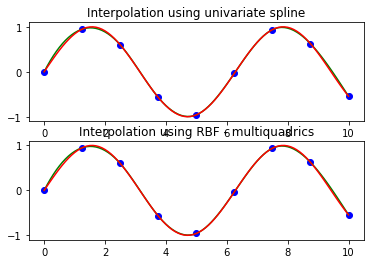

In [6]:
# setup data
x = np.linspace(0, 10, 9)
y = np.sin(x)
xi = np.linspace(0, 10, 101)

# use fitpack2 method
ius = InterpolatedUnivariateSpline(x, y)
yi = ius(xi)

plt.subplot(2, 1, 1)
plt.plot(x, y, 'bo')
plt.plot(xi, yi, 'g')
plt.plot(xi, np.sin(xi), 'r')
plt.title('Interpolation using univariate spline')

# use RBF method
rbf = Rbf(x, y)
fi = rbf(xi)

plt.subplot(2, 1, 2)
plt.plot(x, y, 'bo')
plt.plot(xi, yi, 'g')
plt.plot(xi, np.sin(xi), 'r')
plt.title('Interpolation using RBF - multiquadrics')
plt.savefig('rbf1d.png')

### 2-D example

This example shows how to interpolate scattered 2d data. The dots are the input values.

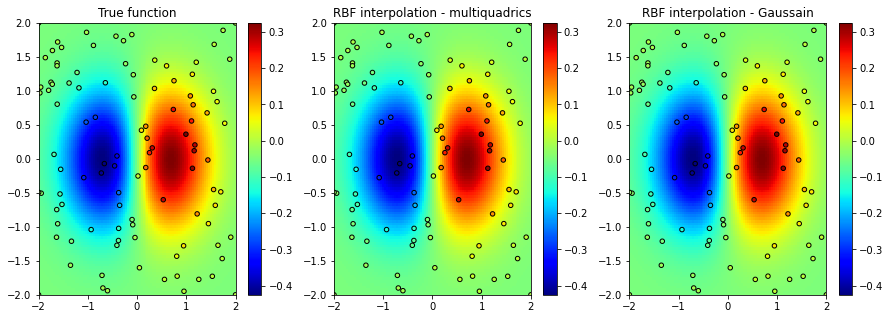

In [7]:
# 2-d tests - setup scattered data
def pfunc(x,y):
    return x*np.exp(-x**2-y**2)

numpoint = 100
x = np.random.rand(numpoint)*4.0-2.0
y = np.random.rand(numpoint)*4.0-2.0
x = np.append(x,[-2,-2,2, 2])
y = np.append(y,[-2, 2,2,-2])
z = pfunc(x,y)
ti = np.linspace(-2.0, 2.0, 100)
XI, YI = np.meshgrid(ti, ti)

# use RBF
rbf = Rbf(x, y, z, epsilon=2)
Zmq = rbf(XI, YI)
rbf = Rbf(x, y, z, function='gaussian',epsilon=1)
Zg = rbf(XI, YI)

# actual curve
Z = pfunc(XI, YI)

# plot the result
# n = plt.Normalize(-2., 2.)
plt.figure(figsize=(15,5))

for subp,zval,title in zip([1,2,3],
                           [Z,Zmq,Zg],
                           ['True function',
                            'RBF interpolation - multiquadrics',
                            'RBF interpolation - Gaussain']):
    plt.subplot(1, 3, subp)
    plt.pcolor(XI, YI, zval, shading='auto', cmap=cm.jet)
    plt.scatter(x, y, 20, z, cmap=cm.jet,edgecolors='k')
    plt.title(title)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.colorbar()

plt.savefig('rbf2d.png')

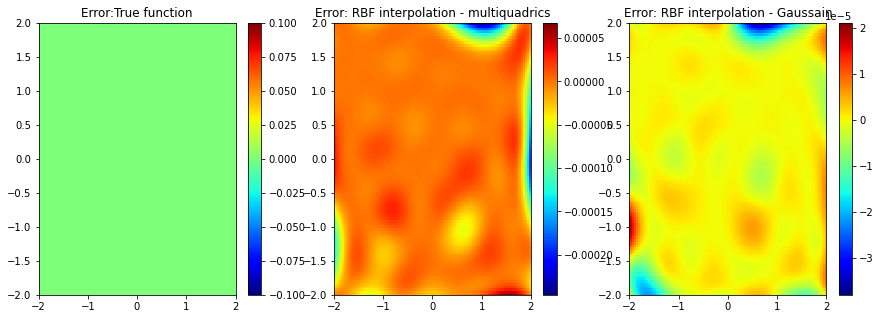

In [8]:
# n = plt.Normalize(-2., 2.)
plt.figure(figsize=(15,5))

for subp,zval,title in zip([1,2,3],
                           [Z,Zmq,Zg],
                           ['Error:True function',
                            'Error: RBF interpolation - multiquadrics',
                            'Error: RBF interpolation - Gaussain']):
    plt.subplot(1, 3, subp)
    plt.pcolor(XI, YI, Z-zval, shading='auto', cmap=cm.jet)
    plt.title(title)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.colorbar()

plt.savefig('rbf2delta.png')

## Alternative implementation

There is a more powerful radial base function package available here:   
https://github.com/treverhines/RBF  
https://rbf.readthedocs.io/en/latest/  
which provides additional capabilities not available in the scipy package.

**Note** It appears that Hines follow the  Scipy convention for $\epsilon = \sigma$ in a Gauss function.

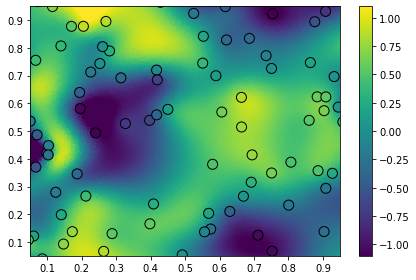

In [9]:
# From Trever Hines' github meadme
''' 
In this example we generate synthetic scattered data with added noise
and then fit it with a smoothed RBF interpolant. The interpolant in
this example is equivalent to a thin plate spline.
'''

from rbf.interpolate import RBFInterpolant
import rbf.basis

np.random.seed(1)

basis = rbf.basis.phs2
order = 1

x_obs = np.random.random((100,2)) # observation points
u_obs = np.sin(2*np.pi*x_obs[:,0])*np.cos(2*np.pi*x_obs[:,1]) # signal
u_obs += np.random.normal(0.0,0.2,100) # add noise to signal
I = RBFInterpolant(x_obs,u_obs,phi='phs3',order=order)
vals = np.linspace(0,1,200)
x_itp = np.reshape(np.meshgrid(vals,vals),(2,200*200)).T # interp points
u_itp = I(x_itp) # evaluate the interpolant

# plot the results
plt.tripcolor(x_itp[:,0],x_itp[:,1],u_itp,vmin=-1.1,vmax=1.1,cmap='viridis')
plt.scatter(x_obs[:,0],x_obs[:,1],s=100,c=u_obs,vmin=-1.1,vmax=1.1,
            cmap='viridis',edgecolor='k')
plt.xlim((0.05,0.95))
plt.ylim((0.05,0.95))
plt.colorbar()
plt.tight_layout()
plt.savefig('RBFinterpolate.png')
plt.show()


## 1-D Periodic interpolation

**The information in this section is based on email conversation wih Trever Hines.**

To answer your question, the RBF package uses euclidean distances between points. If I understand your problem correctly, you want to interpolate 1-D periodic data. This is possible with the RBF package. You just need to use a periodic kernel, which is qualitatively similar to the Von Mises distribution that you mentioned. I included a script demonstrating how to define a periodic kernel and then create a RBFInterpolant with it. You will want to tweak the 'penalty' and 'eps' parameters for RBFInterpolant until you get an interpolant that you like. Let me know if this help



When creating the RBF interpolant with 

    I = RBFInterpolant(phi_obs[:,None],
                                       u_obs,
                                       phi=periodic_rbf,
                                       order=0,
                                       penalty=0.0,
                                       eps=0.3,
                                       ) 
                                       
where `periodic_rbf`  is some periodic basis kernel function.
if `order` is not set to zero, then a linear trend will be added to the interpolant, breaking its periodicity. If `penalty` is given a value greater than zero then the interpolant will become smoother at the expense of not fitting the data exactly. Larger values for `penalty` will result in a smoother interpolant. increasing `eps` results in a longer wavelength interpolant. NOTE: `RBFInterpolant` becomes unstable when `eps` is large and 'penalty' is zero.

In [10]:

import sympy
from sympy import init_printing
init_printing() 



Define a periodic RBF which has a period of 2$\pi$. This is the  periodic covariance function from  https://en.wikipedia.org/wiki/Gaussian_process. First I create a  sympy expression for the periodic RBF, and then I create an RBF  instance with the sympy expression.

In [16]:
import rbf
r = rbf.basis.get_r() # variable for the distance between an point 
                      # and the RBF center
eps = rbf.basis.get_eps() # RBF shape parameter
sympy_expression = sympy.exp(-2*sympy.sin(r/2)**2/eps**2)
periodic_rbf = rbf.basis.RBF(sympy_expression)

print(sympy.latex(sympy_expression))

e^{- \frac{2 \sin^{2}{\left(\frac{r}{2} \right)}}{eps^{2}}}


The radial basis function is:

$$\exp\left[- 2\left(\frac{\sin(0.5 r)}{\epsilon}\right) ^2\right]$$

The $\sin$ terms provides for the periodic pattern and the  square and exponential ensures that the result decreases for values of $r$ far removed from the 2$\pi$ periodic sample points.  It seems that values $\epsilon>0.5$ never quite reaches low values at $\pi$, thereby affecting globally, rather than locally, around each sample point.

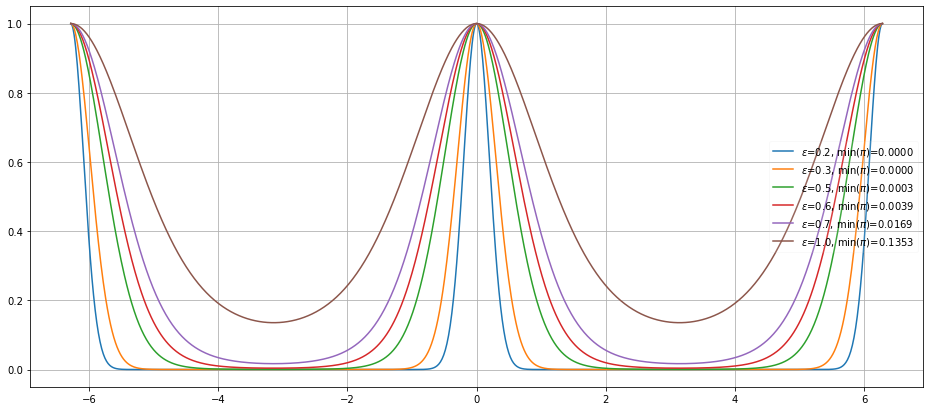

In [17]:
fig, ax = plt.subplots(figsize=(16,7))

for eps in [0.2, 0.3, 0.5,0.6, 0.7, 1.]:
    r = np.linspace(-2*np.pi, 2*np.pi,1000)
    fn = np.exp(-2*((np.sin(r/2)/eps)**2))
    minfn = np.min(fn)

    ax.plot(r, fn,label=f'$\epsilon$={eps}, min($\pi$)={minfn:.4f}')

ax.legend(loc='best', fancybox=True, framealpha=0.1)
ax.grid()

In [18]:
# create 20 instances of fake periodic data 
def createDataset(seed,numpoints=20):
    np.random.seed(seed)
    phi_obs = np.random.uniform(0.0,2*np.pi,numpoints) # observation points 
    u_obs = np.sin(phi_obs) + 0.1*np.sin(10*phi_obs) # observed values
    ##  create the interpolation points
    phi_itp = np.linspace(0.0,2*np.pi,1000)
    # create the true underlying function that we are trying to recover
    truth = np.sin(phi_itp) + 0.1*np.sin(10*phi_itp) 
    return phi_obs, u_obs, phi_itp, truth




Note in the example below, for the random seed value of 0, there is large gap in the sample set between 0.7 and 2.2.
This wide gap plays havoc with the result. This observation points out the importance of carefully optimising $\epsilon$ and also ensuring a reasonably even coverage of sample points.

1. It is clear that for too small $\epsilon$ the RBF's reach is too small to smooth between sample points.

2. A larger value of $\epsilon$ provides good smooth values in regions of sufficiently high sampling, but provides the wrong result where no sampling data are available.

3. Based solely on this example, it would appear that one strategy for selecting $\epsilon$, and to ensure sampling density, would be to find the largest value of $\epsilon$ that provides a 'stable' interpolation solution.  
It might be difficult to find a method to measure this stability norm. 
One approach to stability may be to ensure that the interpolated values do not deviate too much from the mean of all the values.  

4. Observing the results below it seems that there is no harm in pushing for high values of $\epsilon$, provided the sample density is adequate.


In [19]:
def evaluateRBF(seed=0,numpoints=20):
    phi_obs, u_obs, phi_itp, truth = createDataset(seed=seed,numpoints=numpoints)

    fig, ax = plt.subplots(figsize=(16,7))

    for eps in [0.1, 0.2, 0.3,0.4, 0.5]:

        I = RBFInterpolant(
                phi_obs[:,None],u_obs, phi=periodic_rbf,order=0,
                eps=eps,) 
        u_itp = I(phi_itp[:,None])
        ax.plot(phi_itp,u_itp,label=f'interpolated $\epsilon$={eps}')

    plt.title(f'Gaussian RBF seed={seed} numpoints={numpoints}')    
    ax.plot(phi_itp,truth,'k--',label='truth')
    ax.plot(phi_obs,u_obs,'ko',label='observed')
    plt.legend();
    

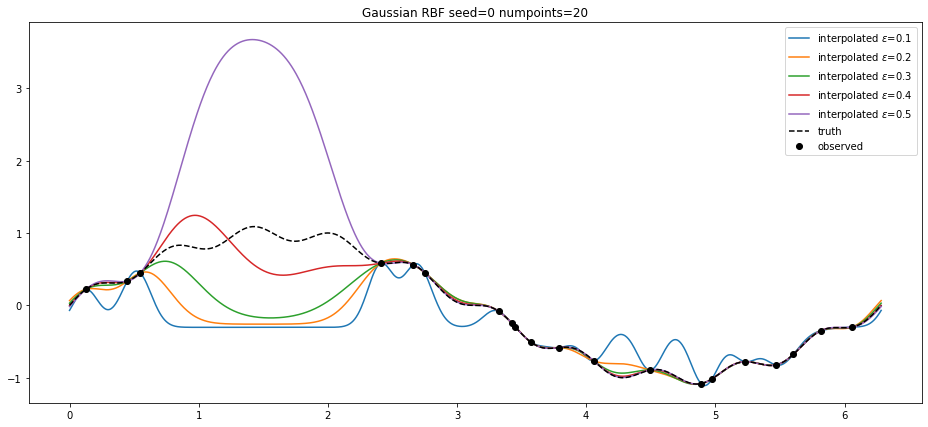

In [20]:
evaluateRBF(seed=0,numpoints=20)

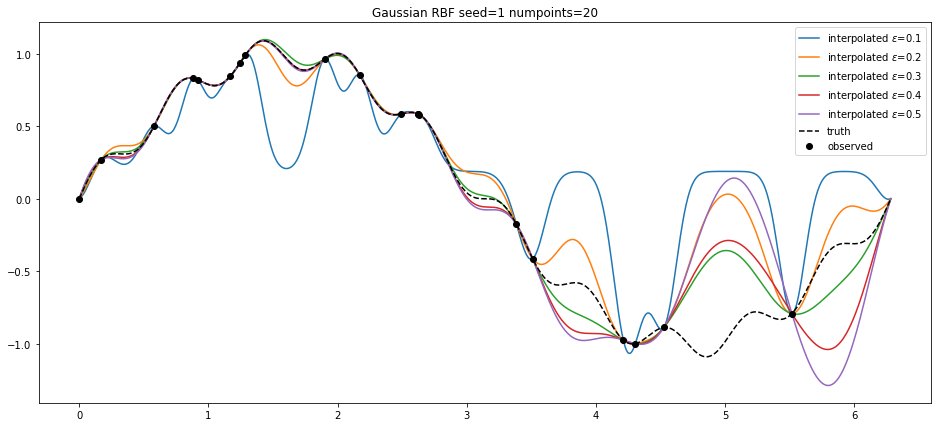

In [21]:
evaluateRBF(seed=1,numpoints=20)

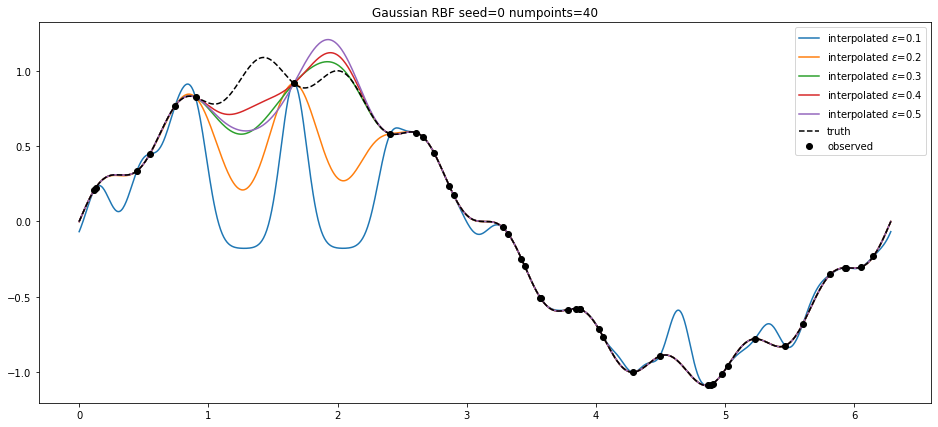

In [22]:
evaluateRBF(seed=0,numpoints=40)

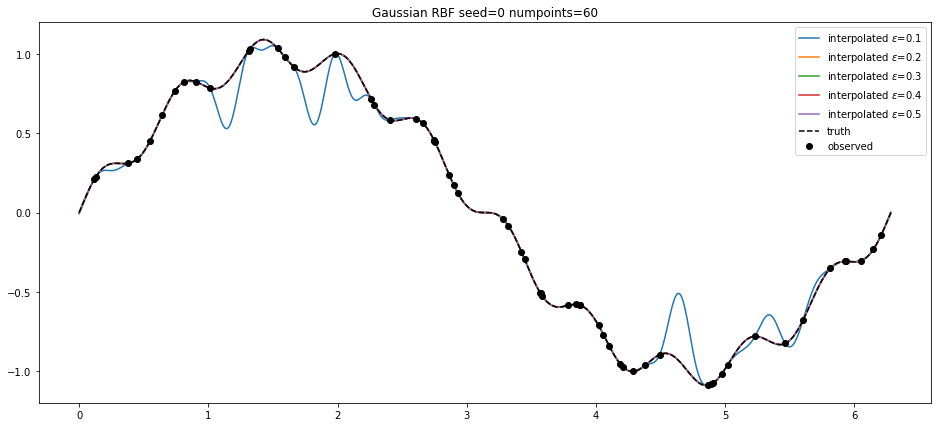

In [23]:
evaluateRBF(seed=0,numpoints=60)

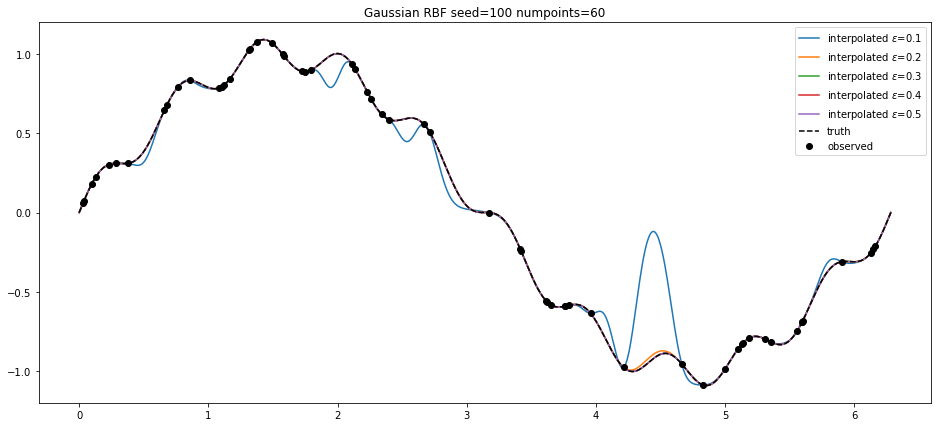

In [24]:
evaluateRBF(seed=100,numpoints=60)

## Interpolation on a sphere


Trever Hines kindly reworked and updated his RBF module to perform interpolation on a sphere.  
The data is converted from azimuth and polar/elevation angles to (x,y,z), which are then interpolated over in the Cartesian domain.  His approach obtain the symmetry around the sphere and does not require any special spherical kernels.  Trever's script is shown below:

mean interpolation error: 0.1923598158217926


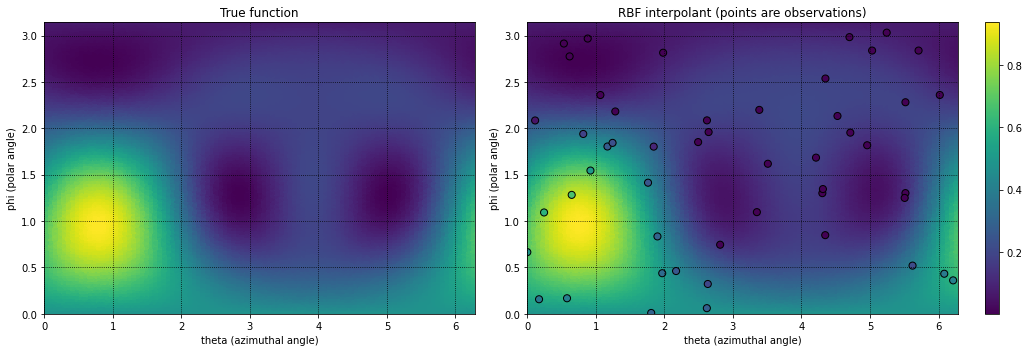

In [25]:
'''
RBF Interpolation on a unit sphere. This is done by converting theta
(azimuthal angle) and phi (polar angle) into cartesian coordinates and
then interpolating over R^3.

Credit: script by Trever Hines (treverhines@gmail.com), using his RBF module.
'''

np.random.seed(1)

def spherical_to_cartesian(theta,phi):
    x = np.sin(phi)*np.cos(theta)  
    y = np.sin(phi)*np.sin(theta)  
    z = np.cos(phi)
    return np.array([x,y,z]).T


def true_function(theta,phi):
    # create some arbitary function that we want to recontruct with
    # interpolation
    cart = spherical_to_cartesian(theta,phi)
    out = (np.cos(cart[:,2] - 1.0) *
         np.cos(cart[:,0] - 1.0) *
         np.cos(cart[:,1] - 1.0))
#     out = np.cos(theta) * np.cos(phi-np.pi/2)
    return out

def sparse_function(theta,phi):
    # create unity data set
    out = true_function(theta,phi)
    out = np.ones(out.shape)
    return out

# sparse is experimental, attempting to see the individual spikes
# it does not seem to work at the moment, clearly my understanding is lacking
sparse = False
    
# number of observation points    
nobs = 5 if sparse else 50
# dataset generating function
dsfunc = sparse_function if sparse else true_function
# eps value
epsvalue = 1 if sparse else 1
# basis function 
basisfunction = rbf.basis.ga if sparse else rbf.basis.phs3


# make the observation points in spherical coordinates 
theta_obs = np.random.uniform(0.0,2*np.pi,nobs)
phi_obs = np.random.uniform(0.0,np.pi,nobs)
# get the catesian coordinates for the observation points
cart_obs = spherical_to_cartesian(theta_obs,phi_obs)
# get the latent function at the observation points
val_obs = dsfunc(theta_obs,phi_obs)
# make a grid of interpolation points in spherical coordinates
thetaV = np.linspace(0.0,2*np.pi,100)
phiV = np.linspace(0.0,np.pi,100)
theta_itp,phi_itp = np.meshgrid(thetaV,phiV)
theta_itp = theta_itp.flatten()
phi_itp = phi_itp.flatten()
# get the catesian coordinates for the interpolation points
cart_itp = spherical_to_cartesian(theta_itp,phi_itp)
# create an RBF interpolant from the cartesian observation points. I
# am just use the default `RBFInterpolant` parameters here, nothing
# special.
# epsvalue = 1
# basisfunction = rbf.basis.phs2
I = RBFInterpolant(cart_obs,val_obs,phi=basisfunction,eps=epsvalue)
# evaluate the interpolant on the interpolation points
val_itp = I(cart_itp)
val_itp = val_itp - np.min(val_itp)

## PLOTTING
plt.figure(figsize=(15,5))

# plot the true function in spherical coordinates
val_true = dsfunc(theta_itp,phi_itp)
plt.subplot(1, 2, 1)
plt.title('True function')
p = plt.tripcolor(theta_itp,phi_itp,val_true,cmap='viridis')
plt.colorbar(p)
plt.xlabel('theta (azimuthal angle)')
plt.ylabel('phi (polar angle)')
plt.xlim(0,2*np.pi)
plt.ylim(0,np.pi)
plt.grid(ls=':',color='k')
plt.tight_layout()

# plot the interpolant in spherical coordinates
plt.subplot(1, 2, 2)
plt.title('RBF interpolant (points are observations)')
# plot the interpolated function
p = plt.tripcolor(theta_itp,phi_itp,val_itp,cmap='viridis')
# plot the observations
plt.scatter(theta_obs,phi_obs,c=val_obs,
            s=50,edgecolor='k',cmap='viridis',
            vmin=p.get_clim()[0],vmax=p.get_clim()[1])                  
plt.colorbar(p)
plt.xlabel('theta (azimuthal angle)')
plt.ylabel('phi (polar angle)')
plt.xlim(0,2*np.pi)
plt.ylim(0,np.pi)
plt.grid()
plt.grid(ls=':',color='k')
plt.tight_layout()

# compute and print the mean L2 error
mean_error = np.mean(np.abs(val_true - val_itp))
print('mean interpolation error: %s' % mean_error)

The following code opens the data set above in a 3-D Mayavi view in a stand-alone window (outside Jupyter).
If you have Mayavi installed, run the code, otherwise study the screen recording below.

    conda install -c conda-forge mayavi
    

In [27]:
if False:
    import numpy as np
    import mayavi.mlab as mlab
    # mlab.options.offscreen = True
    # mlab.init_notebook()
    %gui qt5
    theta_itp,phi_itp = np.meshgrid(thetaV,phiV)
    val_itp = val_itp.reshape(100,100)
    x = val_itp * np.sin(phi_itp) * np.cos(theta_itp)
    y = val_itp * np.sin(phi_itp) * np.sin(theta_itp)
    z = val_itp * np.cos(phi_itp)

    mlab.mesh(x, y, z.reshape(100,100))


The following shell shows a recording of the Mayavi display.  The file is locally saved in the notebook.  It seems that the format must be webm format, the other formats (avi, mp4) did not work.

In [28]:
# display a locally saved video file.
# it seems that only webm format works here
import io
import base64
from IPython.core.display import HTML

filename = './images/interpolationSphere.webm'

# video = io.open(filename, 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''<video alt="Data set video" controls>
#            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#            </video>'''.format(encoded.decode('ascii')))

HTML("""
<div align="middle">
<video width="40%" controls>
      <source src="{}" type="video/mp4">
</video></div>""".format(filename))

## Python and [module versions, and dates](https://github.com/rasbt/watermark)

In [30]:
# to get software versions
# https://github.com/rasbt/watermark
# https://github.com/rasbt/watermark/blob/master/docs/watermark.ipynb
# you only need to do this once
# pip install watermark
# conda install -c conda-forge watermark

%load_ext watermark
%watermark -v -m -p numpy,scipy,rbf,matplotlib,mayavi -g 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.26.0

numpy     : 1.18.5
scipy     : 1.7.1
rbf       : 2019.1.27+208.gb1ca1fa
matplotlib: 3.4.3
mayavi    : 4.7.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 16
Architecture: 64bit

Git hash: 6ff8d2da3032430c034072125971b67e7ee95d57

